# Forcing HMETS with the extended CANOPEX dataset

Here we use ravenpy to launch the HMETS hydrological model and analyze the output. We also prepare and gather data directly from the CANOPEX dataset made available freely for all users.

In [1]:
import warnings

from numba.core.errors import NumbaDeprecationWarning

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)

In [2]:
# Cookie-cutter template necessary to provide the tools, packages and paths for the project. All notebooks
# need this template (or a slightly adjusted one depending on the required packages)
import datetime as dt
import tempfile
from pathlib import Path

import pandas as pd
import spotpy
import xarray as xr

from ravenpy.config import commands as rc
from ravenpy.config.emulators import HMETS
from ravenpy.utilities.calibration import SpotSetup
from ravenpy.utilities.testdata import get_file

# Make a temporary folder
tmp = Path(tempfile.mkdtemp())

In [3]:
# DATA MAIN SOURCE - DAP link to CANOPEX dataset.
CANOPEX_DAP = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ets/Watersheds_5797_cfcompliant.nc"
ds = xr.open_dataset(CANOPEX_DAP)

# Explore the dataset:
display(ds)

<xarray.Dataset>
Dimensions:        (time: 22280, watershed: 5797)
Coordinates:
  * time           (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2010-12-31
  * watershed      (watershed) |S64 b'St. John River at Ninemile Bridge, Main...
Data variables:
    drainage_area  (watershed) float64 ...
    pr             (watershed, time) float64 ...
    tasmax         (watershed, time) float64 ...
    tasmin         (watershed, time) float64 ...
    discharge      (watershed, time) float64 ...
Attributes: (12/15)
    title:          Hydrometeorological data for lumped hydrological modellin...
    institute_id:   ETS
    contact:        Richard Arsenault: richard.arsenault@etsmtl.ca
    date_created:   2020-08-01
    source:         Hydrometric data from USGS National Water Information Ser...
    featureType:    timeSeries
    ...             ...
    activity:       PAVICS_Hydro
    Conventions:    CF-1.6, ACDD-1.3
    summary:        Hydrometeorological database for the PAVICS-Hydro platfor...
    institution:    ETS (École de technologie supérieure)
    DODS.strlen:    72
    DODS.dimName:   string72

In [4]:
# We could explore the dataset and find a watershed of interest, but for now, let's pick one at random
# from the dataset:
watershedID = 5600

# And show what it includes:
ts = ds.isel({"watershed": watershedID})

In [5]:
# Let's write the file to disk to make it more efficient to retrieve:
fname = tmp / "CANOPEX_extracted.nc"
ts.to_netcdf(fname)
ds.close()
ts.close()

In [6]:
# With this info, we can gather some properties from the CANOPEX database. This same database is used for
# regionalization, so let's query it there where more information is available:
tmp = pd.read_csv(get_file("regionalisation_data/gauged_catchment_properties.csv"))

basin_area = float(tmp["area"][watershedID])
basin_latitude = float(tmp["latitude"][watershedID])
basin_longitude = float(tmp["longitude"][watershedID])
basin_elevation = float(tmp["elevation"][watershedID])
basin_name = ds.watershed.data

print("Basin name: ", basin_name)
print("Latitude: ", basin_latitude, " °N")
print("Area: ", basin_area, " km^2")

Basin name:  [b'St. John River at Ninemile Bridge, Maine'
 b'St. John River at Dickey, Maine' b'Fish River near Fort Kent, Maine'
 ... b'MIDDLE THAMES RIVER AT THAMESFORD'
 b'BIG OTTER CREEK AT TILLSONBURG' b'KETTLE CREEK AT ST. THOMAS']
Latitude:  49.51119663557124  °N
Area:  3650.476384548832  km^2


Now, we might have the model and data, but we don't have model parameters! We need to calibrate. This next snippets show how to configure the model and the calibration.

In [7]:
# We will also calibrate on only a subset of the years for now to keep the computations faster in this notebook.
start_calib = dt.datetime(1998, 1, 1)
end_calib = dt.datetime(1999, 12, 31)

# General parameters depending on the data source. We can find them by exploring the CANOPEX dataset in the
# cells above.
data_type = ["TEMP_MAX", "TEMP_MIN", "PRECIP"]

alt_names = {
    "TEMP_MIN": "tasmin",
    "TEMP_MAX": "tasmax",
    "PRECIP": "pr",
}

hru = {}
hru = dict(
    area=basin_area,
    elevation=basin_elevation,
    latitude=basin_latitude,
    longitude=basin_longitude,
    hru_type="land",
)

data_kwds = {
    "ALL": {
        "elevation": hru["elevation"],
        "latitude": hru["latitude"],
        "longitude": hru["longitude"],
    }
}
# Set the evaluation metrics to be calculated by Raven
eval_metrics = ("NASH_SUTCLIFFE",)

model_config = HMETS(
    ObservationData=[
        rc.ObservationData.from_nc(fname, alt_names="discharge", station_idx=1)
    ],
    Gauge=[
        rc.Gauge.from_nc(
            fname,
            station_idx=1,
            data_type=data_type,  # Note that this is the list of all the variables
            alt_names=alt_names,  # Note that all variables here are mapped to their names in the netcdf file.
            data_kwds=data_kwds,
        )
    ],
    HRUs=[hru],
    StartDate=start_calib,
    EndDate=end_calib,
    RunName="CANOPEX_test",
    EvaluationMetrics=eval_metrics,
    RainSnowFraction="RAINSNOW_DINGMAN",
    SuppressOutput=True,
)

In [8]:
# The model parameters bounds can either be set independently or we can use the defaults.
low_params = (
    0.3,
    0.01,
    0.5,
    0.15,
    0.0,
    0.0,
    -2.0,
    0.01,
    0.0,
    0.01,
    0.005,
    -5.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.00001,
    0.0,
    0.00001,
    0.0,
    0.0,
)
high_params = (
    20.0,
    5.0,
    13.0,
    1.5,
    20.0,
    20.0,
    3.0,
    0.2,
    0.1,
    0.3,
    0.1,
    2.0,
    5.0,
    1.0,
    3.0,
    1.0,
    0.02,
    0.1,
    0.01,
    0.5,
    2.0,
)

# Setup the spotpy optimizer
spot_setup = SpotSetup(
    config=model_config,
    low=low_params,
    high=high_params,
)

Finally, we can run the optimizer:

In [9]:
# We'll definitely want to adjust the random seed and number of model evaluations:
model_evaluations = (
    50  # This is to keep computing time fast for the demo, increase as necessary
)

# Setup the spotpy sampler with the method, the setup configuration, a run name and other options. Please refer to
# the spotpy documentation for more options. We recommend sticking to this format for efficiency of most applications.
sampler = spotpy.algorithms.dds(
    spot_setup,
    dbname="CANOPEX_test",
    dbformat="ram",
    save_sim=False,
)

# Launch the actual optimization. Multiple trials can be launched, where the entire process is repeated and
# the best overall value from all trials is returned.
sampler.sample(model_evaluations, trials=1)

Initializing the  Dynamically Dimensioned Search (DDS) algorithm  with  50  repetitions
The objective function will be maximized
Starting the DDS algotrithm with 50 repetitions...
Finding best starting point for trial 1 using 5 random samples.
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
40 of 50, maximal objective function=-24.7202, time remaining: 00:00:00
Best solution found has obj function value of -24.6817 at 5



*** Final SPOTPY summary ***
Total Duration: 2.61 seconds
Total Repetitions: 50
Maximal objective value: -24.6817
Corresponding parameter setting:
GAMMA_SHAPE: 7.63524
GAMMA_SCALE: 0.769725
GAMMA_SHAPE2: 11.4388
GAMMA_SCALE2: 1.0265
MIN_MELT_FACTOR: 17.5457
MAX_MELT_FACTOR: 0.0603
DD_MELT_TEMP: -0.420604
DD_AGGRADATION: 0.01893
SNOW_SWI_MIN: 0.0308324
SNOW_SWI_MAX: 0.0106
SWI_REDUCT_COEFF: 0.1
DD_REFREEZE_TEMP: -0.0332151
REFREEZE_FACTOR: 0.664621
REFREEZE_EXP: 0.958967
PET_CORRECTION: 1.10548
HMETS_RUNOFF_COEFF: 0.214056
PERC_COEFF: 0.011780

[{'sbest': spotpy.parameter.ParameterSet(),
  'trial_initial': [2.4446232183696073,
   3.648993786086633,
   6.808285937892062,
   0.9190984550605087,
   18.936595179011256,
   6.460481436876682,
   -0.48087709565992487,
   0.07545129002831279,
   0.09286020935352743,
   0.03369469595949492,
   0.09584518083667387,
   1.375621144444363,
   0.7970479176500463,
   0.6446325223885151,
   1.9186703071461322,
   0.06648882787110477,
   0.0029416036552497686,
   0.06919911158176603,
   0.0024456422338723837,
   0.44961927013891523,
   0.30659009606737986],
  'objfunc_val': -24.6817}]

In [10]:
# Get the model diagnostics
diag = spot_setup.diagnostics

# Print the NSE and the parameter set in 2 different ways:
print("Nash-Sutcliffe value is: " + str(diag["DIAG_NASH_SUTCLIFFE"]))

# Get all the values of each iteration
results = sampler.getdata()

# Get the raw resutlts directly in an array
params = spotpy.analyser.get_best_parameterset(results)[0]
params

Nash-Sutcliffe value is: [-24.6817]
Best parameter set:
GAMMA_SHAPE=7.635242457794534, GAMMA_SCALE=0.7697246308702375, GAMMA_SHAPE2=11.438816553712229, GAMMA_SCALE2=1.026504937776411, MIN_MELT_FACTOR=17.545677044445164, MAX_MELT_FACTOR=0.0603, DD_MELT_TEMP=-0.42060403078707786, DD_AGGRADATION=0.018930000290900063, SNOW_SWI_MIN=0.030832364134558664, SNOW_SWI_MAX=0.0106, SWI_REDUCT_COEFF=0.1, DD_REFREEZE_TEMP=-0.03321510587203654, REFREEZE_FACTOR=0.6646210627773466, REFREEZE_EXP=0.9589666833784665, PET_CORRECTION=1.1054800200214736, HMETS_RUNOFF_COEFF=0.2140562916769115, PERC_COEFF=0.011780138728707873, BASEFLOW_COEFF_1=0.015517857213688549, BASEFLOW_COEFF_2=0.0034565506868557516, TOPSOIL=0.49493522146275265, PHREATIC=0.14528642601470373


(7.63524246, 0.76972463, 11.43881655, 1.02650494, 17.54567704, 0.0603, -0.42060403, 0.01893, 0.03083236, 0.0106, 0.1, -0.03321511, 0.66462106, 0.95896668, 1.10548002, 0.21405629, 0.01178014, 0.01551786, 0.00345655, 0.49493522, 0.14528643)

At this stage, we have calibrated the model on the observations for the desired dates. Now, let's run the model on a longer time period and look at the hydrograph

In [11]:
from ravenpy import Emulator

conf = model_config.set_params(params)
conf.suppress_output = False
out = Emulator(conf).run()

The `hydrograph` and `storage` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools.

In [12]:
q = out.hydrograph.q_sim

In [13]:
# You can also get statistics from the data directly.
print("Max: ", q.max().values)
print("Mean: ", q.mean().values)
print(
    "Monthly means: ",
    q.groupby("time.month").mean(dim="time").values,
)

Max:  1522.001921641669
Mean:  54.27677750325202
Monthly means:  [[6.93032482e-02]
 [7.86399173e+00]
 [2.87806769e+00]
 [2.16481233e+01]
 [1.84055794e+02]
 [1.31270602e+02]
 [8.73476499e+01]
 [9.45753187e+01]
 [5.70102246e+01]
 [5.79744837e+01]
 [1.88086182e+00]
 [8.44691306e-02]]


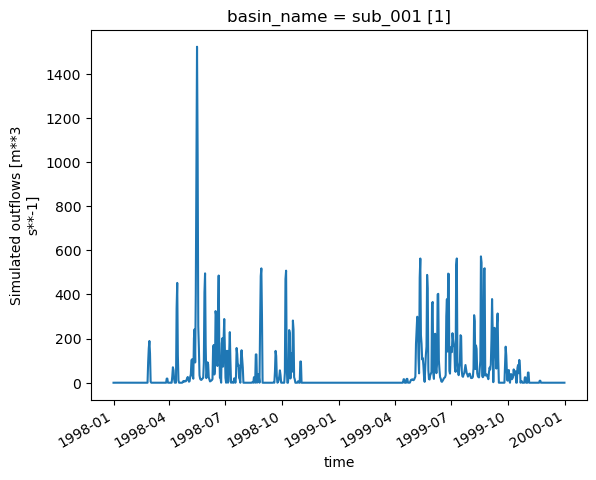

In [14]:
# Plot the simulated hydrograph
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
q.plot()